# TGS Salt Identification Challenge :

Find out more about the competition [here](https://www.kaggle.com/c/tgs-salt-identification-challenge).

## This notebook contains code for:
* visualizing the dataset.
* resizing the input image and corresponding mask to 128x128.
* generating input channels for depth and X,Y-coordinate (following the research in [CoordConv](https://eng.uber.com/coordconv/)).
* custom IOU metric used for evaluating the results.
* a keras callback for visualizing intermediate training performance and pixel-wise classification confidance.
* a deep learning model for underground salt segmentation from seismic images.
* training the model on the 4000 labeled seismic image dataset provided by TGS.
* finding the best threshold value based on validation data results.
* generating the results on the public leaderboard test set.

## Details of the Model:
* the model consists of a shallow "feature-encoder" which uses first 3 blocks of VGG-16 pre-trained on ILSVRC dataset.
* the outputs of this "feature encoder" along with the original image, depth channel and X,Y coordinate channel are then fed into a U-Net like structure with short and long range skip connections.

## Importing Libraries:

In [1]:
from skimage.io import imread,imsave
from keras.models import Model,load_model
from keras.optimizers import SGD,Adam
from keras.layers import *
from skimage.util import pad,crop
from skimage.transform import resize
import os
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint,CSVLogger,EarlyStopping,LearningRateScheduler
import tensorflow as tf
import keras.backend as K
from keras.utils import plot_model
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook as tqdm
import pandas as pd
import numpy as np
K.set_image_data_format('channels_last')

from output_observer import OutputObserver
#from nn import get_model

Using TensorFlow backend.


**_Set local paths for dataset files in the variables below_**

In [2]:
train_csv = r'D:\Datasets\kaggle-TGS-SALT\train.csv'
test_csv = r'D:\Datasets\kaggle-TGS-SALT\test.csv'
depth_csv = r'D:\Datasets\kaggle-TGS-SALT\depths.csv'
train_images_folder = r'D:\Datasets\kaggle-TGS-SALT\train\images'
train_mask_folder = r'D:\Datasets\kaggle-TGS-SALT\train\masks'

## Dataset Visualization:
*you can run the following cell multiple times to get new random samples from the dataset.*

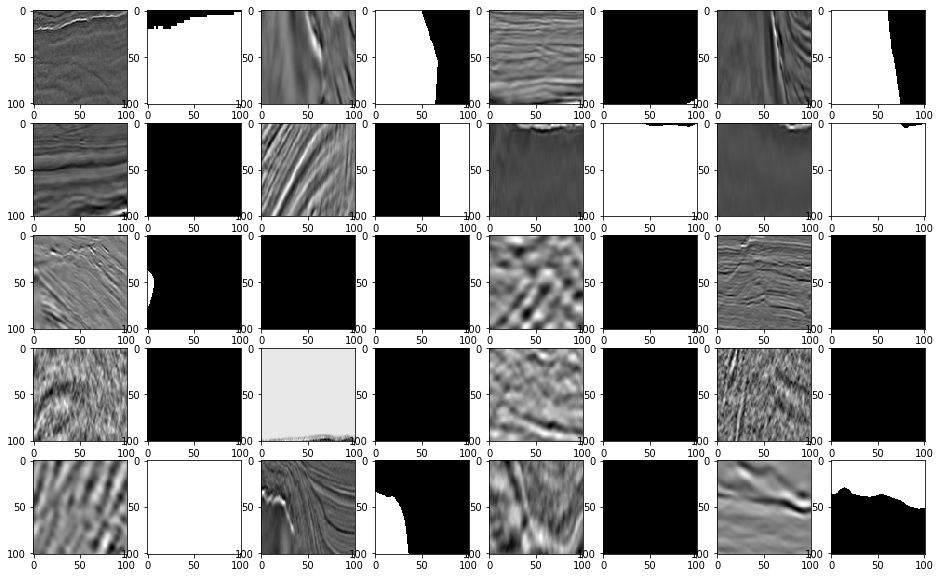

In [3]:
label_df = pd.read_csv(train_csv)
rndperm = np.random.permutation(label_df['id'].shape[0]) # random sample gen for viz purpose
fig = plt.figure(figsize = (16,10))
plt.gray()
for i in tqdm(range(0,40,2)):
    ax = fig.add_subplot(5,8,i+1)
    image_name = label_df.loc[rndperm[i],'id']+'.png'
    #print(image_name)
    image = imread(os.path.join(train_images_folder,image_name))
    ax.imshow(image)
    mask = imread(os.path.join(train_mask_folder,image_name))
    ax = fig.add_subplot(5,8,i+2)
    ax.imshow(mask)

## Processing Input Data:
* Padding the input image and corresponding label to 128x128
* Adding depth and coordinate channels to the input

In [4]:
img_dim = 128

* load input images and masks
* pad the X and y arrays to img_dim x img_dim.
* normalize the y values by dividing all values by 255

In [5]:
X = np.array([pad(imread(os.path.join(train_images_folder,img_name)).astype(np.uint8),pad_width = ((13,14),(13,14),(0,0)),mode='constant') for img_name in tqdm(sorted(os.listdir(train_images_folder)))])[...,0]
y = np.array([pad(imread(os.path.join(train_mask_folder,img_name)).astype(np.uint8),pad_width = ((13,14),(13,14)),mode='constant') for img_name in tqdm(sorted(os.listdir(train_mask_folder)))])[...,None]/255.0

**Create channel for depth :**

In [6]:
depth_df = pd.read_csv(depth_csv,index_col=0)
depth_df_train = depth_df.loc[label_df['id']].sort_values(by='id')
X_depth = np.ones(shape=(len(depth_df_train),img_dim,img_dim),dtype=np.uint8)*np.expand_dims(np.expand_dims(depth_df_train['z'],axis=-1),axis=-1)

 **Create coordinates channels :**

In [7]:
X_coord = np.repeat(np.expand_dims(np.reshape(np.repeat(np.arange(img_dim),img_dim),(img_dim,img_dim)),axis=0),len(depth_df_train),axis=0)
Y_coord = np.copy(np.transpose(X_coord,(0,2,1)))

**Stacking channels to create final input :**

In [8]:
X_in = np.stack([X,X_depth,X_coord,Y_coord],axis=-1)

**Train-Val Split :**

In [9]:
x_train,x_val,y_train,y_val = train_test_split(X_in,y,test_size = 0.1,random_state = 1729)
_,img_rows,img_cols,num_channels = x_train.shape
np.save('x_train',x_train)
np.save('x_val',x_val)
np.save('y_train',y_train)
np.save('y_val',y_val)

# Training:

In [10]:
def get_model(img_rows,img_cols,img_channels,model_name='model1'):
    if not os.path.exists(model_name):
        os.mkdir(model_name)
    inputs = Input((img_rows,img_cols,img_channels))
    inputs_aux = Input((img_rows,img_cols,1))
    '''
    # Block 1
    x = Concatenate()([inputs_aux,inputs_aux,inputs_aux])
    x = Conv2D(64, (3, 3),
        activation='relu',
        padding='same',
        name='block1_conv1',trainable = True)(x)
    x = Conv2D(64, (3, 3),
        activation='relu',
        padding='same',
        name='block1_conv2',trainable = True)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)
    # Block 2
    x = Conv2D(128, (3, 3),
        activation='relu',
        padding='same',
        name='block2_conv1',trainable = True)(x)
    x = Conv2D(128, (3, 3),
        activation='relu',
        padding='same',
        name='block2_conv2',trainable = True)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)
    #Block 3
    x = Conv2D(256, (3, 3),
        activation='relu',
        padding='same',
        name='block3_conv1',trainable = True)(x)
    x = Conv2D(256, (3, 3),
        activation='relu',
        padding='same',
        name='block3_conv2',trainable = True)(x)
    x = Conv2D(256, (3, 3),
        activation='relu',
        padding='same',
        name='block3_conv3',trainable = True)(x)

    t_encoder = Model(inputs = inputs_aux, outputs = x)
    
    #x1 = Concatenate()([t_encoder.get_layer(name = 'block1_conv1').output,t_encoder.get_layer(name = 'block1_conv2').output])
    #x1 = SpatialDropout2D(0.1)(x1)
    #x1 = Conv2D(32,(1,1),padding = 'same',activation = 'elu')(x1)
    x2 = Concatenate()([t_encoder.get_layer(name = 'block2_conv1' ).output,t_encoder.get_layer(name = 'block2_conv2' ).output])
    x2 = SpatialDropout2D(0.2)(x2)
    x2 = Conv2D(32,(1,1), padding = 'same', activation = 'elu')(x2)
    x2 = UpSampling2D((2,2))(x2)
    x3 = Concatenate()([t_encoder.get_layer(name = 'block3_conv1' ).output,t_encoder.get_layer(name = 'block3_conv2' ).output,t_encoder.get_layer(name = 'block3_conv3' ).output])
    x3 = SpatialDropout2D(0.3)(x3)
    x3 = Conv2D(64,(1,1),padding = 'same', activation = 'elu')(x3)
    x3 = UpSampling2D((4,4))(x3)
    
    x_concat = Concatenate()([x2,x3])

    x_concat = SpatialDropout2D(0.5)(x_concat)
    x = Concatenate()([inputs,x_concat])
    x = Conv2D(64,(1,1),activation = 'elu')(x)
    '''
    x = Conv2D(64,(3,3),padding = 'same',activation = 'elu')(inputs)
    x_skip_1 = Conv2D(64,(3,3),padding = 'same',activation = 'elu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x_skip_1)

    x = Conv2D(64,(3,3),padding = 'same',activation = 'elu')(x)
    x_skip_2 = Conv2D(64,(3,3),padding = 'same',activation = 'elu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x_skip_2)

    x = Conv2D(128,(3,3),padding = 'same',activation = 'elu')(x)
    x = Conv2D(128,(3,3),padding = 'same',activation = 'elu')(x)
    x_skip_3 = Conv2D(128,(3,3),padding = 'same',activation = 'elu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x_skip_3)

    x = Conv2D(128,(3,3),padding = 'same',activation = 'elu')(x)
    x = Conv2D(128,(3,3),padding = 'same',activation = 'elu')(x)
    x_skip_4 = Conv2D(128,(3,3),padding = 'same',activation = 'elu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x_skip_4)

    x = Conv2D(256,(3,3),padding = 'same',activation = 'elu')(x)
    x = Conv2D(256,(3,3),padding = 'same',activation = 'elu')(x)
    #x = Conv2D(256,(3,3),padding = 'same',activation = 'elu')(x)

    #x = Conv2DTranspose(filters = 128,kernel_size = (2,2),strides = 2)(x)
    x = UpSampling2D((2,2))(x)
    x = Concatenate()([x,SpatialDropout2D(0.5)(x_skip_4)])
    x = Conv2D(128,(3,3),padding = 'same',activation = 'elu')(x)
    x = Conv2D(128,(3,3),padding = 'same',activation = 'elu')(x)
    #x = Conv2D(128,(3,3),padding = 'same',activation = 'elu')(x)

    #x = Conv2DTranspose(filters = 128,kernel_size = (2,2),strides = 2)(x)
    x = UpSampling2D((2,2))(x)
    x = Concatenate()([x,SpatialDropout2D(0.5)(x_skip_3)])
    x = Conv2D(128,(3,3),padding = 'same',activation = 'elu')(x)
    x = Conv2D(128,(3,3),padding = 'same',activation = 'elu')(x)
    #x = Conv2D(128,(3,3),padding = 'same',activation = 'elu')(x)

    #x = Conv2DTranspose(filters = 64,kernel_size = (2,2),strides = 2)(x)
    x = UpSampling2D((2,2))(x)
    x = Concatenate()([x,SpatialDropout2D(0.5)(x_skip_2)])
    x = Conv2D(64,(3,3),padding = 'same',activation = 'elu')(x)
    x = Conv2D(64,(3,3),padding = 'same',activation = 'elu')(x)

    #x = Conv2DTranspose(filters = 32,kernel_size = (2,2),strides = 2)(x)
    x = UpSampling2D((2,2))(x)
    x = Concatenate()([x,SpatialDropout2D(0.5)(x_skip_1)])
    x = Conv2D(64,(3,3),padding = 'same',activation = 'elu')(x)
    x = Conv2D(64,(3,3),padding = 'same',activation = 'elu')(x)

    x = Conv2D(1,(1,1),activation = 'sigmoid',name = 'final_out')(x)

    model1 = Model(inputs = [inputs,inputs_aux], outputs = [x])
    #model1.load_weights(r'D:\Weights\vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',by_name = True)

    return model1

In [11]:
model_nn = get_model(img_rows,img_cols,num_channels,model_name = 'model1')
print(model_nn.summary())
model_nn.compile(optimizer=Adam(lr=1e-3), loss='binary_crossentropy',metrics = ['accuracy'])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 4)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 2368        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 64, 64, 64)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

Total params: 3,101,249
Trainable params: 3,101,249
Non-trainable params: 0
__________________________________________________________________________________________________
None


In [1]:
#callbacks
model_name='model1'
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience = 3, verbose = 1, min_lr = 1e-6)
model_checkpoint = ModelCheckpoint(os.path.join(model_name,'model.h5'), monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False)
logger = CSVLogger(os.path.join(model_name,'logger.log'))
early_stop = EarlyStopping(monitor = 'val_loss' , patience = 6,verbose = 1)
#train
#model_nn.load_weights(r'D:\Weights\vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',by_name = True)
results = model_nn.fit([x_train,np.expand_dims(x_train[...,0],axis=-1)],y_train,validation_data = ([x_val,np.expand_dims(x_val[...,0],axis=-1)],y_val),epochs = 100,
            callbacks = [model_checkpoint,reduce_lr,logger,OutputObserver(x_val[...,0],y_val),early_stop] ,shuffle = True, verbose = 1, batch_size = 8)

NameError: name 'ReduceLROnPlateau' is not defined

# Training Results:

In [ ]:
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(results.epoch, results.history["loss"], label="Train loss")
ax_loss.plot(results.epoch, results.history["val_loss"], label="Validation loss")
ax_acc.plot(results.epoch, results.history["acc"], label="Train accuracy")
ax_acc.plot(results.epoch, results.history["val_acc"], label="Validation accuracy")

# Best Threshold Selection:

In [ ]:
model = load_model(r'D:\Notebooks\Kaggle-TGS-Salt\model5\model.h5')
y_pred = model.predict(x_val,batch_size = 1,verbose = 1)
thres = np.linspace(0.25, 0.80, 20)
thres_ioc = [iou_metric_batch(y_val, np.int32(y_pred > t)) for t in thres]
plt.plot(thres, thres_ioc)
plt.show()
best_thres = thres[np.argmax(thres_ioc)]
print('best threshold:',best_thres,'max threshold value:' ,max(thres_ioc))

# Testing:

In [ ]:
def runlenE(image):
    image = image.flatten(order = 'F')
    i = 0
    enc = []
    while i != len(image) and image[i] != 1:
        i+=1
    while i != len(image):
        enc.append(i+1)
        count = 0
        while i != len(image) and image[i] == 1:
            i+=1
            count+=1
        enc.append(count)
        while i != len(image) and image[i] != 1:
            i+=1
    return ' '.join(map(str,enc))

In [ ]:
X_test = np.array([pad(imread(os.path.join(train_image_folder,img_name)).astype(np.uint8),pad_width=((13,14),(13,14),(0,0))) for img_name in tqdm(sorted(os.listdir(train_image_folder)))])[...,0]
X_depth_test = np.array([np.ones(shape=(img_dim,img_dim,1))*row['z'] for i,row in tqdm(test_depth_df.iterrows())])
X_coord = np.repeat(np.expand_dims(np.reshape(np.repeat(np.arange(img_dim),img_dim),(img_dim,img_dim)),axis=0),len(test_data_df),axis=0)
Y_coord = Y_coord = np.copy(np.transpose(X_coord,(0,2,1)))
X_test = np.stack(X_test,X_depth_test,X_coord,Y_coord)

In [ ]:
model = load_model(r'D:\Notebooks\Kaggle-TGS-Salt\model4\model.h5')
masks = model.predict([X_test[...,0],X_test],batch_size=1,verbose=True)[...,0]
masks = crop(masks,((0,0),(13,14),(13,14)))
masks = masks > 0.7

In [ ]:
pred_dict = {os.path.splitext(fname)[0]:runlenE(masks[i]) for i,fname in enumerate(os.listdir(r'D:\Datasets\kaggle-TGS-SALT\test\images'))}
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission.csv')